In [1]:
import environment
import numpy as np
from td3_torch import Agent
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    running_avg_score = np.zeros(len(scores))
    for i in range(len(running_avg_score)):
        running_avg_score[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg_score, '-b')
    plt.title('Média móvel das últimas 100 pontuações')
    plt.savefig(figure_file)

def plot_success_curve(x, successes, figure_file):
    running_success_rate = np.zeros(len(successes))
    for i in range(len(running_success_rate)):
        running_success_rate[i] = np.mean(successes[max(0, i-50):(i+1)])
    plt.plot(x, running_success_rate, '-g')
    plt.title('Taxa de sucesso dos últimos 50 episódios')
    plt.savefig(figure_file)

def plot_step_curve(x, steps, figure_file):
    running_step_avg = np.zeros(len(steps))
    for i in range(len(running_step_avg)):
        running_step_avg[i] = np.mean(steps[max(0, i-200):(i+1)])
    plt.plot(x, running_step_avg, '-g')
    plt.title('Média móvel da duração dos últimos 200 episódios')
    plt.savefig(figure_file)

In [2]:
import mujoco
import mediapy as media
import random

class MujocoEnv1_0:
    def __init__(self):
        self.high = 1
        self.low = -1
        self.state_dim = 8
        self.action_dim = 2
        self.name = "MujocoEnv-v1-0"
        self.theta1 = 0
        self.theta2 = 0
        self.model = mujoco.MjModel.from_xml_path("C:\Kuka_RL_Control-main\sim_env\environmentS.xml")
        self.data = mujoco.MjData(self.model)
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.framerate = 24
        self.frames = []
        mujoco.mj_forward(self.model, self.data)
        self.data.ctrl[6] = 0.05
        self.dt = 0.1

    def reset(self):
        mujoco.mj_resetData(self.model, self.data)
        mujoco.mj_forward(self.model, self.data)
        self.frames = []
        self.data.ctrl[6] = 0.05
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.data.qpos[0:3] = [-1,-1,2.5]
        self.data.qvel[0:3] = [2.75,1,3]
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        x0,y0,z0 = self.data.qpos[0:3].copy()
        vx0,vy0,vz0 = self.data.qvel[0:3].copy()
        return (theta1,theta2,x0,y0,z0,vx0,vy0,vz0)
    
    def calculaTarget(self):
        x0,y0,z0 = self.data.qpos[0:3].copy()
        vx0,vy0,vz0 = self.data.qvel[0:3].copy()
        tempo_queda = (vz0+np.sqrt(np.abs(vz0**2+2*9.8*(z0-0.589))))/9.8
        targetx = x0 + tempo_queda*vx0
        targety = y0 + tempo_queda*vy0
        return targetx, targety
    def calculaDistanciaTarget(self, targetx, targety):
        return np.sqrt((self.data.geom_xpos[9,0].copy()-targetx)**2 + (self.data.geom_xpos[9,1].copy()-targety)**2)
    def calculaDistancia(self):
        xo,yo,zo = self.data.geom_xpos[1].copy()
        xc,yc,zc = self.data.geom_xpos[9].copy()
        return np.sqrt((xo-xc)**2+(yo-yc)**2+(zo-zc)**2)

    def step(self, action):
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
        distancia = self.calculaDistanciaTarget(*self.calculaTarget())
        reward = -5*distancia
        if self.data.time > 3 or self.data.qpos[2] < 0.2:
            done = True
        if self.calculaDistancia() < 0.05:
            done = True
            reward += 200
            print('success')
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        x0,y0,z0 = self.data.qpos[0:3].copy()
        vx0,vy0,vz0 = self.data.qvel[0:3].copy()
        return (theta1,theta2,x0,y0,z0,vx0,vy0,vz0), reward, done

    def rstep(self, action):
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
            if len(self.frames) < self.data.time * self.framerate:
                self.renderer.update_scene(self.data,camera='depth_camera0')
                pixels = self.renderer.render()
                self.frames.append(pixels)
        distancia = self.calculaDistanciaTarget(*self.calculaTarget())
        reward = -10*distancia**2
        if self.data.time > 3 or self.data.qpos[2] < 0.2:
            done = True
        if self.calculaDistancia() < 0.05:
            done = True
            reward += 200
            print('success')
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        x0,y0,z0 = self.data.qpos[0:3].copy()
        vx0,vy0,vz0 = self.data.qvel[0:3].copy()
        return (theta1,theta2,x0,y0,z0,vx0,vy0,vz0), reward, done

class MujocoEnv1_1:
    def __init__(self):
        self.high = 1
        self.low = -1
        self.state_dim = 4
        self.action_dim = 2
        self.name = "MujocoEnv-v1-1"
        self.theta1 = 0
        self.theta2 = 0
        self.x0 = 0
        self.y0 = 0
        self.z0 = 0
        self.vx0 = 0
        self.vy0 = 0
        self.vz0 = 0
        self.targetx = 0
        self.targety = 0
        self.model = mujoco.MjModel.from_xml_path("C:\Kuka_RL_Control-main\sim_env\environmentS.xml")
        self.data = mujoco.MjData(self.model)
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.framerate = 24
        self.frames = []
        mujoco.mj_forward(self.model, self.data)
        self.data.ctrl[6] = 0.05
        self.dt = 0.1

    def calculaTarget(self):
        tempo_queda = (self.vz0+np.sqrt(self.vz0**2+2*9.8*(self.z0-0.589)))/9.8
        self.targetx = self.x0 + tempo_queda*self.vx0
        self.targety = self.y0 + tempo_queda*self.vy0

    def calculaDistanciaTarget(self):
        return np.sqrt((self.data.geom_xpos[9,0].copy()-self.targetx)**2 + (self.data.geom_xpos[9,1].copy()-self.targety)**2)

    def getGoodBola(self):
        d=0
        while d < 1 or d > 1.8:
            self.x0 = random.uniform(-1.5,1.5)
            self.y0 = random.uniform(-1.5,1.5)
            self.z0 = random.uniform(2,3)
            self.vx0 = random.uniform(-2,2)
            self.vy0 = random.uniform(-2,2)
            self.vz0 = random.uniform(2,3)
            self.calculaTarget()
            d = np.sqrt(self.targetx**2+self.targety**2)

    def reset(self):
        mujoco.mj_resetData(self.model, self.data)
        mujoco.mj_forward(self.model, self.data)
        self.frames = []
        self.data.ctrl[6] = 0.3
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)

        self.getGoodBola()
        self.calculaTarget()
        xc,yc,zc = self.data.geom_xpos[9].copy()
        self.data.qpos[0:3] = [self.x0,self.y0,self.z0]
        self.data.qvel[0:3] = [self.vx0,self.vy0,self.vz0]
        mujoco.mj_forward(self.model, self.data)
        return (xc,yc,self.targetx,self.targety)

    def step(self, action):
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2
        if self.data.time > 5:
            done = True
        if distancia < 0.05:
            done = True
            reward += 200
            print('success')
        xc,yc,zc = self.data.geom_xpos[9].copy()
        return (xc,yc,self.targetx,self.targety), reward, done

    def rstep(self, action):
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
            if len(self.frames) < self.data.time * self.framerate:
                self.renderer.update_scene(self.data,camera='depth_camera0')
                pixels = self.renderer.render()
                self.frames.append(pixels)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2
        if self.data.time > 5:
            done = True
        if distancia < 0.05:
            done = True
            reward += 200
            print('success')
            self.data.ctrl[0:6] = [0,0,0,0,0,0]
            while self.data.time < 5:
                mujoco.mj_step(self.model, self.data)
                if len(self.frames) < self.data.time * self.framerate:
                    self.renderer.update_scene(self.data,camera='depth_camera0')
                    pixels = self.renderer.render()
                    self.frames.append(pixels)
        xc,yc,zc = self.data.geom_xpos[9].copy()
        return (xc,yc,self.targetx,self.targety), reward, done

class MujocoEnv1_2:
    def __init__(self):
        self.high = 1
        self.low = -1
        self.state_dim = 4
        self.action_dim = 2
        self.name = "MujocoEnv-v1-2"
        self.theta1 = 0
        self.theta2 = 0
        self.x0 = 0
        self.y0 = 0
        self.z0 = 0
        self.vx0 = 0
        self.vy0 = 0
        self.vz0 = 0
        self.targetx = 0
        self.targety = 0
        self.model = mujoco.MjModel.from_xml_path("C:\Kuka_RL_Control-main\sim_env\environmentS.xml")
        self.data = mujoco.MjData(self.model)
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.framerate = 24
        self.frames = []
        mujoco.mj_forward(self.model, self.data)
        self.data.ctrl[6] = 0.05
        self.dt = 0.1

    def calculaTarget(self):
        tempo_queda = (self.vz0+np.sqrt(self.vz0**2+2*9.8*(self.z0-0.589)))/9.8
        self.targetx = self.x0 + tempo_queda*self.vx0
        self.targety = self.y0 + tempo_queda*self.vy0

    def calculaDistanciaTarget(self):
        return np.sqrt((self.data.geom_xpos[9,0].copy()-self.targetx)**2 + (self.data.geom_xpos[9,1].copy()-self.targety)**2)

    def getGoodBola(self):
        d=0
        while d < 1 or d > 1.8:
            self.x0 = random.uniform(-1.5,1.5)
            self.y0 = random.uniform(-1.5,1.5)
            self.z0 = random.uniform(2,3)
            self.vx0 = random.uniform(-2,2)
            self.vy0 = random.uniform(-2,2)
            self.vz0 = random.uniform(2,3)
            self.calculaTarget()
            d = np.sqrt(self.targetx**2+self.targety**2)

    def reset(self):
        mujoco.mj_resetData(self.model, self.data)
        mujoco.mj_forward(self.model, self.data)
        self.frames = []
        self.data.ctrl[6] = 0.3
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)

        self.getGoodBola()
        self.calculaTarget()
        xc,yc,zc = self.data.geom_xpos[9].copy()
        self.data.qpos[0:3] = [self.x0,self.y0,self.z0]
        self.data.qvel[0:3] = [self.vx0,self.vy0,self.vz0]
        mujoco.mj_forward(self.model, self.data)
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.targetx,self.targety)

    def step(self, action):
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2
        if self.data.time > 5:
            done = True
        if distancia < 0.05:
            done = True
            reward += 200
            print('success')
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.targetx,self.targety), reward, done

    def rstep(self, action):
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
            if len(self.frames) < self.data.time * self.framerate:
                self.renderer.update_scene(self.data,camera='depth_camera0')
                pixels = self.renderer.render()
                self.frames.append(pixels)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2
        if self.data.time > 5:
            done = True
        if distancia < 0.05:
            done = True
            reward += 200
            print('success')
            self.data.ctrl[0:6] = [0,0,0,0,0,0]
            while self.data.time < 5:
                mujoco.mj_step(self.model, self.data)
                if len(self.frames) < self.data.time * self.framerate:
                    self.renderer.update_scene(self.data,camera='depth_camera0')
                    pixels = self.renderer.render()
                    self.frames.append(pixels)
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.targetx,self.targety), reward, done

class MujocoEnv0_0:
    def __init__(self):
        self.high = 1
        self.low = -1
        self.state_dim = 4
        self.action_dim = 2
        self.name = "MujocoEnv-v0-0"
        self.theta1 = 0
        self.theta2 = 0
        self.targetx = 0
        self.targety = 0
        self.model = mujoco.MjModel.from_xml_path("C:\Kuka_RL_Control-main\sim_env\environmentS.xml")
        self.data = mujoco.MjData(self.model)
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.framerate = 24
        self.frames = []
        mujoco.mj_forward(self.model, self.data)
        self.data.ctrl[6] = 0.05
        self.dt = 0.1

    def reset(self):
        mujoco.mj_resetData(self.model, self.data)
        mujoco.mj_forward(self.model, self.data)
        self.frames = []
        self.data.ctrl[6] = 0.05
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        xc,yc,zc = self.data.geom_xpos[9].copy()
        ang = random.uniform(-np.pi,np.pi)
        r = random.uniform(1,1.7)
        self.targetx = r*np.sin(ang)
        self.targety = r*np.cos(ang)
        return (xc,yc,self.targetx,self.targety)
    
    def calculaDistanciaTarget(self, targetx, targety):
        return np.sqrt((self.data.geom_xpos[9,0].copy()-targetx)**2 + (self.data.geom_xpos[9,1].copy()-targety)**2)
    
    def step(self, action):
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
        distancia = self.calculaDistanciaTarget(self.targetx,self.targety)
        reward = -2*distancia -2
        if self.data.time > 5:
            done = True
        if distancia < 0.15:
            done = True
            reward += 200
            print('success')
        xc,yc,zc = self.data.geom_xpos[9].copy()
        return (xc,yc,self.targetx,self.targety), reward, done

    def rstep(self, action):
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
            if len(self.frames) < self.data.time * self.framerate:
                self.renderer.update_scene(self.data,camera='depth_camera0')
                pixels = self.renderer.render()
                self.frames.append(pixels)
        distancia = self.calculaDistanciaTarget(self.targetx,self.targety)
        reward = -2*distancia -2
        if self.data.time > 5:
            done = True
        if distancia < 0.15:
            done = True
            reward += 200
            print('success')
        xc,yc,zc = self.data.geom_xpos[9].copy()
        return (xc,yc,self.targetx,self.targety), reward, done

class MujocoEnv2_0:
    def __init__(self):
        self.high = 1
        self.low = -1
        self.state_dim = 8
        self.action_dim = 2
        self.name = "MujocoEnv-v2-0"
        self.theta1 = 0
        self.theta2 = 0
        self.x0 = 0
        self.y0 = 0
        self.z0 = 0
        self.vx0 = 0
        self.vy0 = 0
        self.vz0 = 0
        self.targetx = 0
        self.targety = 0
        self.model = mujoco.MjModel.from_xml_path("C:\Kuka_RL_Control-main\sim_env\environmentS.xml")
        self.data = mujoco.MjData(self.model)
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.framerate = 24
        self.frames = []
        mujoco.mj_forward(self.model, self.data)
        self.data.ctrl[6] = 0.05
        self.dt = 0.1
        self.tfin = 0

    def calculaTarget(self):
        tempo_queda = (self.vz0+np.sqrt(self.vz0**2+2*9.8*(self.z0-0.589)))/9.8
        self.targetx = self.x0 + tempo_queda*self.vx0
        self.targety = self.y0 + tempo_queda*self.vy0

    def calculaDistanciaTarget(self):
        return np.sqrt((self.data.geom_xpos[9,0].copy()-self.targetx)**2 + (self.data.geom_xpos[9,1].copy()-self.targety)**2)

    def getGoodBola(self):
        d=0
        while d < 1 or d > 1.8:
            self.x0 = random.uniform(-1.5,1.5)
            self.y0 = random.uniform(-1.5,1.5)
            self.z0 = random.uniform(2,3)
            self.vx0 = random.uniform(-2,2)
            self.vy0 = random.uniform(-2,2)
            self.vz0 = random.uniform(2,3)
            self.calculaTarget()
            d = np.sqrt(self.targetx**2+self.targety**2)

    def reset(self):
        mujoco.mj_resetData(self.model, self.data)
        mujoco.mj_forward(self.model, self.data)
        self.frames = []
        self.data.ctrl[6] = 0.3
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.tfin = 0
        self.getGoodBola()
        self.calculaTarget()
        xc,yc,zc = self.data.geom_xpos[9].copy()
        self.data.qpos[0:3] = [self.x0,self.y0,self.z0]
        self.data.qvel[0:3] = [self.vx0,self.vy0,self.vz0]
        mujoco.mj_forward(self.model, self.data)
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0)

    def step(self, action):
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2-distancia**2
        if self.data.time > 5:
            done = True
            self.tfin = self.data.time
        if distancia < 0.07:
            done = True
            reward += 200
            print('success')
            self.tfin = self.data.time
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0), reward, done

    def rstep(self, action):
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
            if len(self.frames) < self.data.time * self.framerate:
                self.renderer.update_scene(self.data,camera='depth_camera0')
                pixels = self.renderer.render()
                self.frames.append(pixels)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2-distancia**2
        if self.data.time > 5:
            done = True
            self.tfin = self.data.time
        if distancia < 0.05:
            done = True
            self.tfin = self.data.time
            reward += 200
            print('success')
            self.data.ctrl[0:6] = [0,0,0,0,0,0]
            while self.data.time < 5:
                mujoco.mj_step(self.model, self.data)
                if len(self.frames) < self.data.time * self.framerate:
                    self.renderer.update_scene(self.data,camera='depth_camera0')
                    pixels = self.renderer.render()
                    self.frames.append(pixels)
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0), reward, done

class MujocoEnv2_1:
    def __init__(self):
        self.high = 1
        self.low = -1
        self.state_dim = 8
        self.action_dim = 2
        self.name = "MujocoEnv-v2-1"
        self.theta1 = 0
        self.theta2 = 0
        self.x0 = 0
        self.y0 = 0
        self.z0 = 0
        self.vx0 = 0
        self.vy0 = 0
        self.vz0 = 0
        self.targetx = 0
        self.targety = 0
        self.dist = 0.45
        self.model = mujoco.MjModel.from_xml_path("C:\Kuka_RL_Control-main\sim_env\environmentS.xml")
        self.data = mujoco.MjData(self.model)
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.framerate = 24
        self.frames = []
        mujoco.mj_forward(self.model, self.data)
        self.data.ctrl[6] = 0.05
        self.dt = 0.1
        self.tfin = 0

    def calculaTarget(self):
        tempo_queda = (self.vz0+np.sqrt(self.vz0**2+2*9.8*(self.z0-0.589)))/9.8
        self.targetx = self.x0 + tempo_queda*self.vx0
        self.targety = self.y0 + tempo_queda*self.vy0

    def calculaDistanciaTarget(self):
        return np.sqrt((self.data.geom_xpos[9,0].copy()-self.targetx)**2 + (self.data.geom_xpos[9,1].copy()-self.targety)**2)

    def getGoodBola(self):
        d=0
        while d < 1 or d > 1.8:
            self.x0 = random.uniform(-1.5,1.5)
            self.y0 = random.uniform(-1.5,1.5)
            self.z0 = random.uniform(2,3)
            self.vx0 = random.uniform(-2,2)
            self.vy0 = random.uniform(-2,2)
            self.vz0 = random.uniform(2,3)
            self.calculaTarget()
            d = np.sqrt(self.targetx**2+self.targety**2)

    def setNextDistancia(self):
        if self.dist>0.06:
            self.dist = self.dist*0.8

    def reset(self):
        mujoco.mj_resetData(self.model, self.data)
        mujoco.mj_forward(self.model, self.data)
        self.frames = []
        self.data.ctrl[6] = 0.3
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.tfin = 0
        self.getGoodBola()
        self.calculaTarget()
        xc,yc,zc = self.data.geom_xpos[9].copy()
        self.data.qpos[0:3] = [self.x0,self.y0,self.z0]
        self.data.qvel[0:3] = [self.vx0,self.vy0,self.vz0]
        mujoco.mj_forward(self.model, self.data)
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0)

    def step(self, action):
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2-distancia**2
        if self.data.time > 5:
            done = True
            self.tfin = self.data.time
        if distancia < self.dist:
            done = True
            reward += 200
            print('success')
            self.tfin = self.data.time
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0), reward, done

    def rstep(self, action):
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
            if len(self.frames) < self.data.time * self.framerate:
                self.renderer.update_scene(self.data,camera='depth_camera0')
                pixels = self.renderer.render()
                self.frames.append(pixels)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2-distancia**2
        if self.data.time > 5:
            done = True
            self.tfin = self.data.time
        if distancia < self.dist:
            done = True
            self.tfin = self.data.time
            reward += 200
            print('success')
            self.data.ctrl[0:6] = [0,0,0,0,0,0]
            while self.data.time < 5:
                mujoco.mj_step(self.model, self.data)
                if len(self.frames) < self.data.time * self.framerate:
                    self.renderer.update_scene(self.data,camera='depth_camera0')
                    pixels = self.renderer.render()
                    self.frames.append(pixels)
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0), reward, done

class MujocoEnv2_2:
    def __init__(self):
        self.high = 1
        self.low = -1
        self.state_dim = 8
        self.action_dim = 2
        self.name = "MujocoEnv-v2-2"
        self.theta1 = 0
        self.theta2 = 0
        self.x0 = 0
        self.y0 = 0
        self.z0 = 0
        self.vx0 = 0
        self.vy0 = 0
        self.vz0 = 0
        self.targetx = 0
        self.targety = 0
        self.distlist = [1.6,0.8,0.4,0.06]
        self.distcount = 0
        self.model = mujoco.MjModel.from_xml_path("C:\Kuka_RL_Control-main\sim_env\environmentS.xml")
        self.data = mujoco.MjData(self.model)
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.framerate = 24
        self.frames = []
        mujoco.mj_forward(self.model, self.data)
        self.data.ctrl[6] = 0.05
        self.dt = 0.1
        self.tfin = 0
        self.successes = 0

    def calculaTarget(self):
        tempo_queda = (self.vz0+np.sqrt(self.vz0**2+2*9.8*(self.z0-0.589)))/9.8
        self.targetx = self.x0 + tempo_queda*self.vx0
        self.targety = self.y0 + tempo_queda*self.vy0

    def calculaDistanciaTarget(self):
        return np.sqrt((self.data.geom_xpos[9,0].copy()-self.targetx)**2 + (self.data.geom_xpos[9,1].copy()-self.targety)**2)

    def getGoodBola(self):
        d=0
        while d < 1 or d > 1.8:
            self.x0 = random.uniform(-1.5,1.5)
            self.y0 = random.uniform(-1.5,1.5)
            self.z0 = random.uniform(2,3)
            self.vx0 = random.uniform(-2,2)
            self.vy0 = random.uniform(-2,2)
            self.vz0 = random.uniform(2,3)
            self.calculaTarget()
            d = np.sqrt(self.targetx**2+self.targety**2)

    def reset(self):
        mujoco.mj_resetData(self.model, self.data)
        mujoco.mj_forward(self.model, self.data)
        self.frames = []
        self.data.ctrl[6] = 0.3
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.tfin = 0
        self.getGoodBola()
        self.calculaTarget()
        d = self.calculaDistanciaTarget()
        self.distlist = [0.75*d,0.5*d,0.25*d,0.06]
        if d < 0.06: self.distlist = [0.06]
        self.distcount = 0
        xc,yc,zc = self.data.geom_xpos[9].copy()
        self.data.qpos[0:3] = [self.x0,self.y0,self.z0]
        self.data.qvel[0:3] = [self.vx0,self.vy0,self.vz0]
        mujoco.mj_forward(self.model, self.data)
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0)

    def step(self, action):
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2-distancia**2
        if self.data.time > 5:
            done = True
            self.tfin = self.data.time
        if distancia < self.distlist[self.distcount]:
            self.distcount += 1
            reward += 100
            self.successes += 1
        if self.distcount == len(self.distlist):
            done = True
            reward += 100
            print('success')
            self.tfin = self.data.time
            self.data.ctrl[0:6] = [0,0,0,0,0,0]
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0), reward, done

    def rstep(self, action):
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
            if len(self.frames) < self.data.time * self.framerate:
                self.renderer.update_scene(self.data,camera='depth_camera0')
                pixels = self.renderer.render()
                self.frames.append(pixels)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2-distancia**2
        if self.data.time > 5:
            done = True
            self.tfin = self.data.time
        if distancia < self.distlist[self.distcount]:
            self.distcount += 1
            reward += 100
            self.successes += 1
        if self.distcount == len(self.distlist):
            done = True
            reward += 100
            print('success')
            self.tfin = self.data.time
            self.data.ctrl[0:6] = [0,0,0,0,0,0]
            while self.data.time < 5:
                mujoco.mj_step(self.model, self.data)
                if len(self.frames) < self.data.time * self.framerate:
                    self.renderer.update_scene(self.data,camera='depth_camera0')
                    pixels = self.renderer.render()
                    self.frames.append(pixels)
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0), reward, done






actor  is running on  cuda:0
critic_1  is running on  cuda:0
critic_2  is running on  cuda:0
target_actor  is running on  cuda:0
target_critic_1  is running on  cuda:0
target_critic_2  is running on  cuda:0
episode 0  score -313.85  average score -313.85  n_steps 50
episode 1  score -174.08  average score -243.96  n_steps 50
episode 2  score -278.07  average score -255.33  n_steps 50
episode 3  score -63.82  average score -207.45  n_steps 50
episode 4  score -148.28  average score -195.62  n_steps 50
episode 5  score -235.33  average score -202.24  n_steps 50
episode 6  score -316.84  average score -218.61  n_steps 50
episode 7  score -96.66  average score -203.36  n_steps 50
episode 8  score -126.17  average score -194.79  n_steps 50
episode 9  score -130.62  average score -188.37  n_steps 50
episode 10  score -304.95  average score -198.97  n_steps 50
episode 11  score -179.02  average score -197.31  n_steps 50
episode 12  score 73.94  average score -176.44  n_steps 21
episode 13  sc

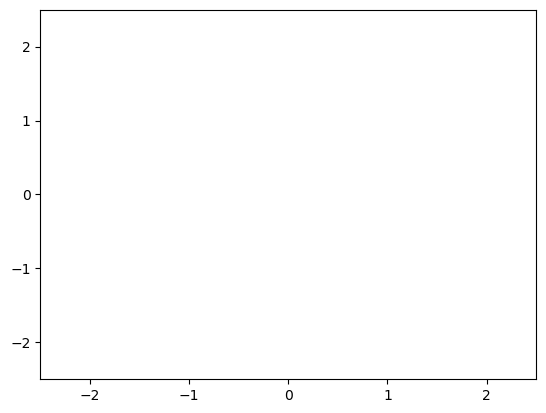

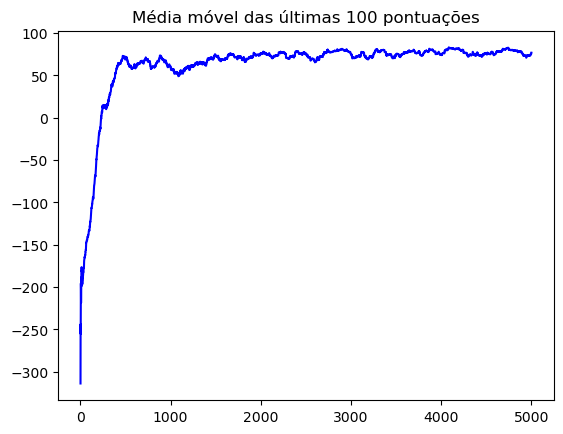

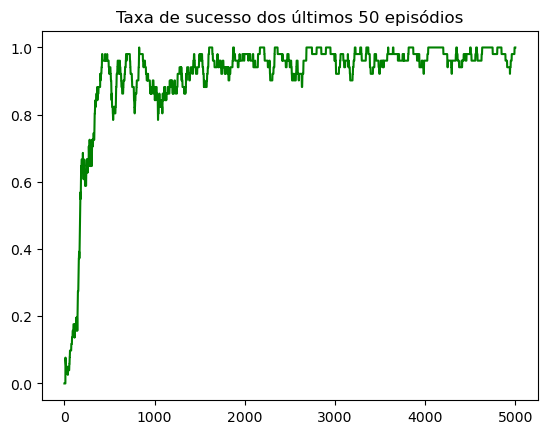

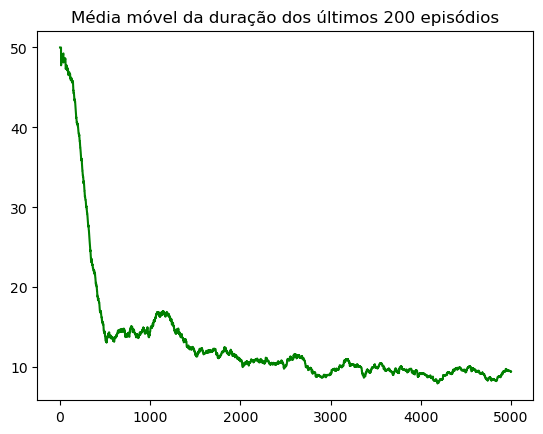

In [2]:
if __name__ == '__main__':
    #%matplotlib qt
    plt.ion()
    env = environment.FormiguinhaPBraco3_t2()
    agent = Agent(alpha=0.001, beta=0.001, input_dims=env.state_dim, tau=0.005, env_low=env.low, 
                  env_high=env.high, batch_size=100, layer1_size=1600, layer2_size=1000, n_actions=env.action_dim)
    #agent.load_models()
    n_games = 5000
    filename = env.name + '_alpha' + str(agent.alpha) + '_beta_' + str(agent.beta) + "_" + str(n_games) + '_games'
    figure_file_score = 'plots/' + filename + '_score.png'
    figure_file_catchrate = 'plots/' + filename + '_catchrate.png'
    figure_file_steps = 'plots/' + filename + '_steps.png'
    animationTH = n_games
    best_score = -9999999
    step_history = []
    score_history = []
    success_history = []
    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        success = 0
        plt.axis([-2.5, 2.5, -2.5, 2.5])
        if i>=animationTH:
            plt.scatter(env.targetx, env.targety, marker='x', c='red')
            plt.scatter(env.targetx, env.targety, marker='o', c='red', s=1000, alpha=0.05)
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done = env.step(action)
            agent.remember(observation, action, reward, observation_, done)
            agent.learn()
            score += reward
            observation = observation_
            if reward > 0: success = 1
            if i >= animationTH:
                plt.scatter(env.posx, env.posy, marker='o', c='blue')
                plt.pause(0.01)
        if i >= animationTH:
            plt.pause(0.5)
            plt.clf()
        step_history.append(env.t)
        score_history.append(score)
        success_history.append(success)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score and i>100:
            best_score = avg_score
            agent.save_models()

        print('episode', i, ' score %.2f' %score, ' average score %.2f' %avg_score, ' n_steps %d' %env.t)
    x = [i+1 for i in range(n_games)]
    %matplotlib inline
    plt.figure('learning')
    plot_learning_curve(x, score_history, figure_file_score)
    plt.figure('catching')
    plot_success_curve(x, success_history, figure_file_catchrate)
    plt.figure('steps')
    plot_step_curve(x, step_history, figure_file_steps)

actor  is running on  cuda:0
critic_1  is running on  cuda:0
critic_2  is running on  cuda:0
target_actor  is running on  cuda:0
target_critic_1  is running on  cuda:0
target_critic_2  is running on  cuda:0
episode 0  score -812.39  average score -812.39  time 5.0125
episode 1  score -562.94  average score -687.67  time 5.0125
episode 2  score -379.13  average score -584.82  time 5.0125
episode 3  score -940.07  average score -673.63  time 5.0125
episode 4  score -686.15  average score -676.13  time 5.0125
episode 5  score -537.24  average score -652.99  time 5.0125
episode 6  score -735.50  average score -664.77  time 5.0125
episode 7  score -640.93  average score -661.79  time 5.0125
episode 8  score -220.82  average score -612.80  time 5.0125
episode 9  score -718.96  average score -623.41  time 5.0125
episode 10  score -694.18  average score -629.85  time 5.0125
episode 11  score -607.39  average score -627.97  time 5.0125
episode 12  score -821.21  average score -642.84  time 5.01

episode 2499  score -243.53  average score -181.80  time 5.0125
success
episode 2500  score 182.03  average score -178.38  time 0.6005
episode 2501  score -284.75  average score -182.80  time 5.0125
episode 2502  score -246.24  average score -183.58  time 5.0125
episode 2503  score -249.69  average score -184.32  time 5.0125
episode 2504  score -310.70  average score -185.99  time 5.0125
episode 2505  score -254.92  average score -186.40  time 5.0125
episode 2506  score -276.30  average score -187.50  time 5.0125
episode 2507  score -223.46  average score -187.33  time 5.0125
episode 2508  score -412.75  average score -189.72  time 5.0125
episode 2509  score -137.83  average score -189.14  time 5.0125
episode 2510  score -225.14  average score -189.03  time 5.0125
episode 2511  score -148.24  average score -192.03  time 5.0125
episode 2512  score -387.63  average score -197.12  time 5.0125
episode 2513  score -395.75  average score -199.06  time 5.0125
success
episode 2514  score 149.9

episode 4999  score -250.39  average score -122.08  time 5.0125


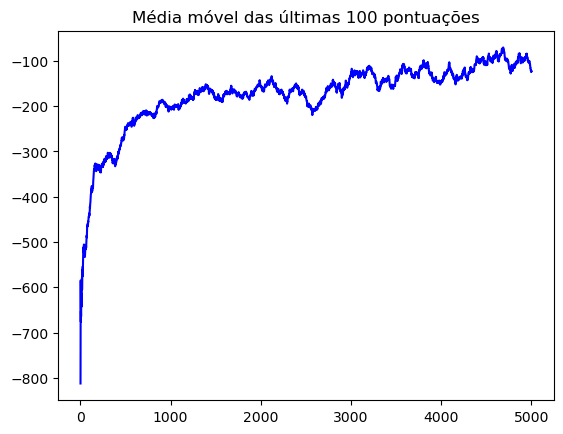

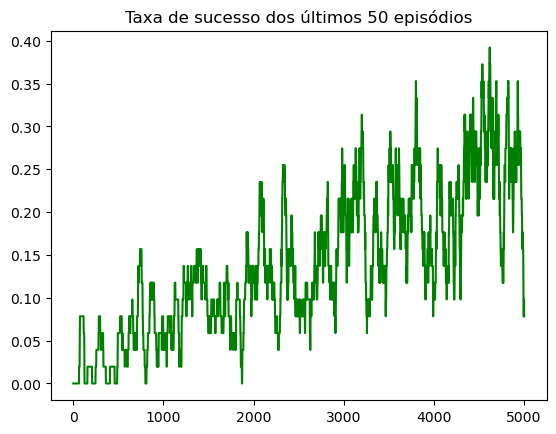

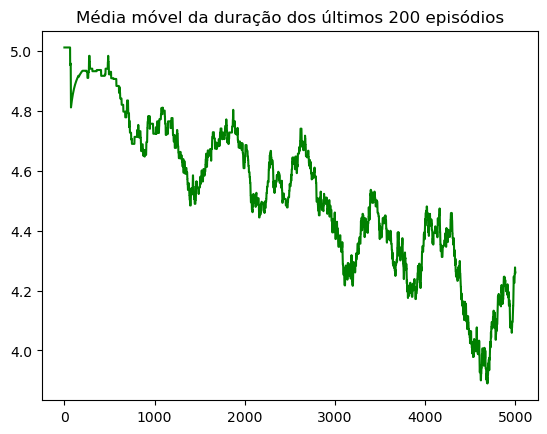

In [3]:
# PARA MUJOCO

if __name__ == '__main__':
    env = MujocoEnv2_0()
    agent = Agent(alpha=0.001, beta=0.001, input_dims=env.state_dim, tau=0.005, env_low=env.low, 
                  env_high=env.high, batch_size=100, layer1_size=1600, layer2_size=1000, n_actions=env.action_dim)
    #agent.load_models()
    n_games = 5000
    filename = env.name + '_alpha' + str(agent.alpha) + '_beta_' + str(agent.beta) + "_" + str(n_games) + '_games'
    figure_file_score = 'plots/' + filename + '_score.png'
    figure_file_catchrate = 'plots/' + filename + '_catchrate.png'
    figure_file_steps = 'plots/' + filename + '_steps.png'
    best_score = -9999999
    time_history = []
    score_history = []
    success_history = []
    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        success = 0
        if i%2500 != 2499:
            while not done:
                action = agent.choose_action(observation)
                observation_, reward, done = env.step(action)
                agent.remember(observation, action, reward, observation_, done)
                agent.learn()
                score += reward
                observation = observation_
                if reward > 0: success = 1
        else:
            while not done:
                action = agent.choose_action(observation)
                observation_, reward, done = env.rstep(action)
                agent.remember(observation, action, reward, observation_, done)
                agent.learn()
                score += reward
                observation = observation_
                if reward > 0: success = 1
            media.show_video(env.frames, fps=env.framerate)
            
        time_history.append(env.tfin)
        score_history.append(score)
        success_history.append(success)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score and i>100:
            best_score = avg_score
            agent.save_models()

        print('episode', i, ' score %.2f' %score, ' average score %.2f' %avg_score, ' time %.4f' %env.data.time)
    x = [i+1 for i in range(n_games)]
    %matplotlib inline
    plt.figure('learning')
    plot_learning_curve(x, score_history, figure_file_score)
    plt.figure('catching')
    plot_success_curve(x, success_history, figure_file_catchrate)
    plt.figure('steps')
    plot_step_curve(x, time_history, figure_file_steps)

In [5]:
# PARA MUJOCO ARTIFICIOS RECOMPENSA

if __name__ == '__main__':
    env = MujocoEnv2_1()
    agent = Agent(alpha=0.001, beta=0.001, input_dims=env.state_dim, tau=0.005, env_low=env.low, 
                  env_high=env.high, batch_size=100, layer1_size=1600, layer2_size=1000, n_actions=env.action_dim)
    #agent.load_models()
    n_games = 30001
    filename = env.name + '_alpha' + str(agent.alpha) + '_beta_' + str(agent.beta) + "_" + str(n_games) + '_games'
    figure_file_score = 'plots/' + filename + '_score.png'
    figure_file_catchrate = 'plots/' + filename + '_catchrate.png'
    figure_file_steps = 'plots/' + filename + '_steps.png'
    best_score = -9999999
    time_history = []
    score_history = []
    success_history = []
    partial_success_history = []
    next_level_points = []
    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        success = 0
        if i not in [200,1000,2000,5000,10000,15000,22000,30000]:
            while not done:
                action = agent.choose_action(observation)
                observation_, reward, done = env.step(action)
                agent.remember(observation, action, reward, observation_, done)
                agent.learn()
                score += reward
                observation = observation_
                if reward > 0: success = 1
        else:
            while not done:
                action = agent.choose_action(observation)
                observation_, reward, done = env.rstep(action)
                agent.remember(observation, action, reward, observation_, done)
                agent.learn()
                score += reward
                observation = observation_
                if reward > 0: success = 1
            media.show_video(env.frames, fps=env.framerate)
            
        time_history.append(env.tfin)
        score_history.append(score)
        success_history.append(success)
        partial_success_history.append(success)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score and i>100:
            best_score = avg_score
            agent.save_models()
        
        if len(partial_success_history)>800 and np.mean(partial_success_history[-100:])>0.9:
            partial_success_history = []
            env.setNextDistancia()
            next_level_points.append(i)
            print('NEXT LEVEL')

        print('episode', i, ' score %.2f' %score, ' average score %.2f' %avg_score, ' time %.4f' %env.data.time)
        print('episode', i, ' partial success avg %.2f' %np.mean(partial_success_history[-100:]), ' dist %.2f' %env.dist)
    x = [i+1 for i in range(n_games)]
    %matplotlib inline
    plt.figure('learning')
    plot_learning_curve(x, score_history, figure_file_score)
    plt.figure('catching')
    plot_success_curve(x, success_history, figure_file_catchrate)
    plt.figure('steps')
    plot_step_curve(x, time_history, figure_file_steps)

actor  is running on  cuda:0
critic_1  is running on  cuda:0
critic_2  is running on  cuda:0
target_actor  is running on  cuda:0
target_critic_1  is running on  cuda:0
target_critic_2  is running on  cuda:0
episode 0  score -981.85  average score -981.85  time 5.0125
episode 0  partial success avg 0.00  dist 0.45
episode 1  score -262.86  average score -622.35  time 5.0125
episode 1  partial success avg 0.00  dist 0.45
episode 2  score -852.67  average score -699.13  time 5.0125
episode 2  partial success avg 0.00  dist 0.45
episode 3  score -820.17  average score -729.39  time 5.0125
episode 3  partial success avg 0.00  dist 0.45
episode 4  score -699.95  average score -723.50  time 5.0125
episode 4  partial success avg 0.00  dist 0.45
episode 5  score -708.12  average score -720.94  time 5.0125
episode 5  partial success avg 0.00  dist 0.45
success
episode 6  score 15.34  average score -615.76  time 4.6105
episode 6  partial success avg 0.14  dist 0.45
episode 7  score -1054.11  aver

episode 200  score -271.47  average score 24.87  time 5.0125
episode 200  partial success avg 0.74  dist 0.45
episode 201  score -391.80  average score 19.85  time 5.0125
episode 201  partial success avg 0.73  dist 0.45
episode 202  score -386.80  average score 18.83  time 5.0125
episode 202  partial success avg 0.73  dist 0.45
episode 203  score -210.43  average score 14.92  time 5.0125
episode 203  partial success avg 0.72  dist 0.45
success
episode 204  score 170.50  average score 21.37  time 0.5000
episode 204  partial success avg 0.73  dist 0.45
episode 205  score -363.11  average score 15.81  time 5.0125
episode 205  partial success avg 0.72  dist 0.45
episode 206  score -169.50  average score 12.70  time 5.0125
episode 206  partial success avg 0.71  dist 0.45
episode 207  score -301.25  average score 8.90  time 5.0125
episode 207  partial success avg 0.70  dist 0.45
success
episode 208  score 103.56  average score 13.09  time 0.9020
episode 208  partial success avg 0.71  dist 0.

episode 1000  score 187.67  average score 88.89  time 5.0005
episode 1000  partial success avg 0.84  dist 0.45
success
episode 1001  score 196.92  average score 94.41  time 0.1000
episode 1001  partial success avg 0.85  dist 0.45
success
episode 1002  score 189.45  average score 94.73  time 0.3000
episode 1002  partial success avg 0.85  dist 0.45
episode 1003  score -225.69  average score 91.08  time 5.0125
episode 1003  partial success avg 0.84  dist 0.45
success
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
episode 1004  score 164.78  average score 95.77  time 0.5000
episode 1004  partial success avg 0.85  dist 0.45
success
episode 1005  score 143.44  average score 95.39  time 0.8015
episode 1005  partial success avg 0.85  dist 0.45
success
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... sav

c:\Users\gianl\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\gianl\miniconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


episode 1042  partial success avg nan  dist 0.36
success
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
episode 1043  score 144.30  average score 117.28  time 0.7010
episode 1043  partial success avg 1.00  dist 0.36
success
episode 1044  score 112.78  average score 116.48  time 0.9020
episode 1044  partial success avg 1.00  dist 0.36
success
episode 1045  score 197.59  average score 117.18  time 0.1000
episode 1045  partial success avg 1.00  dist 0.36
success
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
episode 1046  score 193.43  average score 118.65  time 0.2000
episode 1046  partial success avg 1.00  dist 0.36
success
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint

episode 2000  score 100.34  average score 104.17  time 5.0005
episode 2000  partial success avg 0.88  dist 0.29
success
episode 2001  score 85.08  average score 103.18  time 1.7060
episode 2001  partial success avg 0.88  dist 0.29
success
episode 2002  score 177.57  average score 103.28  time 0.5000
episode 2002  partial success avg 0.88  dist 0.29
success
episode 2003  score 175.99  average score 103.30  time 0.5000
episode 2003  partial success avg 0.88  dist 0.29
success
episode 2004  score 107.71  average score 102.50  time 0.9020
episode 2004  partial success avg 0.88  dist 0.29
success
episode 2005  score 143.61  average score 102.29  time 0.8015
episode 2005  partial success avg 0.88  dist 0.29
success
episode 2006  score 87.49  average score 101.35  time 1.1030
episode 2006  partial success avg 0.88  dist 0.29
success
episode 2007  score 165.71  average score 101.17  time 0.7010
episode 2007  partial success avg 0.88  dist 0.29
success
episode 2008  score 174.89  average score 

episode 5000  score 190.06  average score 97.26  time 5.0005
episode 5000  partial success avg 0.87  dist 0.15
success
episode 5001  score 164.57  average score 98.16  time 0.7010
episode 5001  partial success avg 0.87  dist 0.15
success
episode 5002  score 175.93  average score 99.18  time 0.5000
episode 5002  partial success avg 0.87  dist 0.15
success
episode 5003  score 181.79  average score 99.23  time 0.4000
episode 5003  partial success avg 0.87  dist 0.15
success
episode 5004  score 197.73  average score 100.61  time 0.1000
episode 5004  partial success avg 0.87  dist 0.15
success
episode 5005  score 189.74  average score 101.45  time 0.4000
episode 5005  partial success avg 0.87  dist 0.15
success
episode 5006  score 43.86  average score 100.70  time 2.1075
episode 5006  partial success avg 0.87  dist 0.15
episode 5007  score -236.27  average score 99.73  time 5.0125
episode 5007  partial success avg 0.87  dist 0.15
success
episode 5008  score 146.92  average score 99.43  time

episode 10000  score 147.24  average score 84.76  time 5.0005
episode 10000  partial success avg 0.84  dist 0.06
success
episode 10001  score 148.95  average score 85.14  time 0.9020
episode 10001  partial success avg 0.84  dist 0.06
success
episode 10002  score 168.83  average score 85.57  time 1.0025
episode 10002  partial success avg 0.84  dist 0.06
success
episode 10003  score 126.09  average score 85.32  time 1.8065
episode 10003  partial success avg 0.84  dist 0.06
success
episode 10004  score 125.10  average score 85.15  time 3.1075
episode 10004  partial success avg 0.84  dist 0.06
success
episode 10005  score 175.71  average score 88.54  time 0.8015
episode 10005  partial success avg 0.85  dist 0.06
episode 10006  score -130.09  average score 86.56  time 5.0125
episode 10006  partial success avg 0.84  dist 0.06
episode 10007  score -202.69  average score 82.64  time 5.0125
episode 10007  partial success avg 0.83  dist 0.06
episode 10008  score -202.02  average score 79.89  tim

episode 15000  score 119.45  average score 111.85  time 5.0005
episode 15000  partial success avg 0.92  dist 0.05
success
episode 15001  score 122.83  average score 115.07  time 2.4075
episode 15001  partial success avg 0.93  dist 0.05
success
episode 15002  score 90.00  average score 114.41  time 4.2085
episode 15002  partial success avg 0.93  dist 0.05
success
episode 15003  score 178.53  average score 115.02  time 0.7010
episode 15003  partial success avg 0.93  dist 0.05
success
episode 15004  score 179.97  average score 116.04  time 0.6005
episode 15004  partial success avg 0.93  dist 0.05
success
episode 15005  score 60.96  average score 115.05  time 2.0075
episode 15005  partial success avg 0.93  dist 0.05
success
episode 15006  score 85.62  average score 114.57  time 2.8075
episode 15006  partial success avg 0.93  dist 0.05
success
episode 15007  score 151.88  average score 114.91  time 0.7010
episode 15007  partial success avg 0.93  dist 0.05
success
episode 15008  score 157.46

KeyboardInterrupt: 

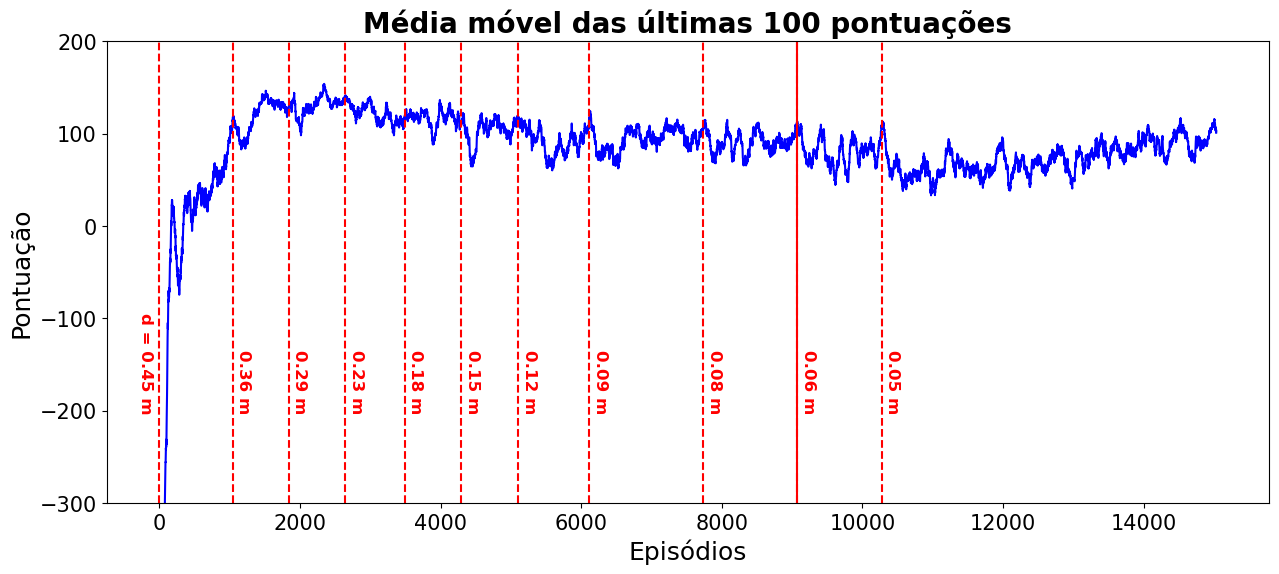

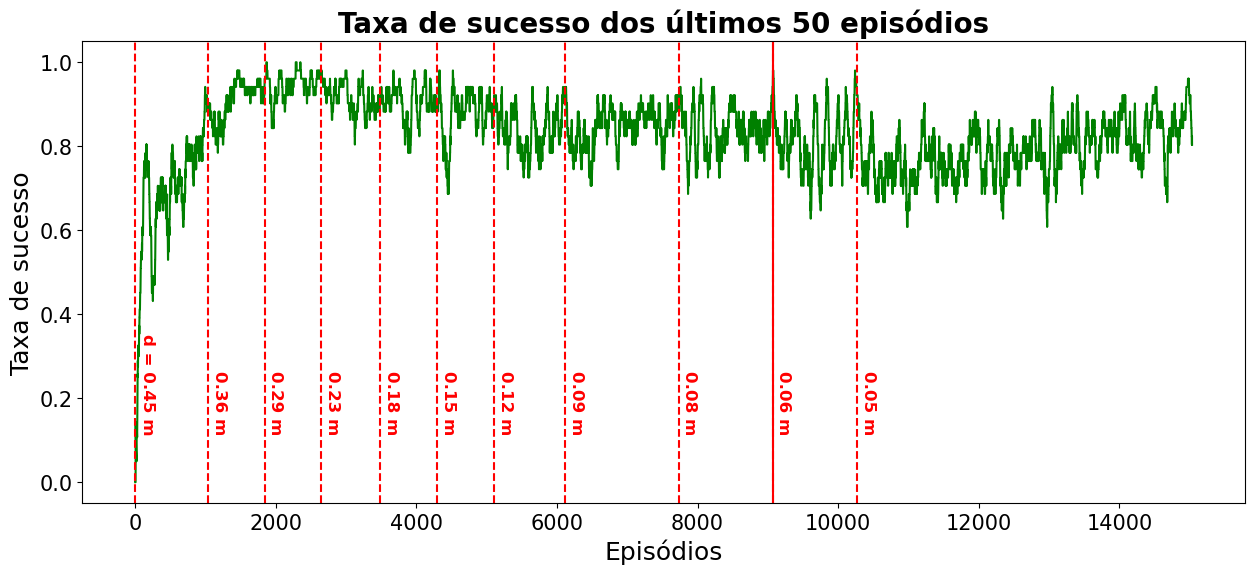

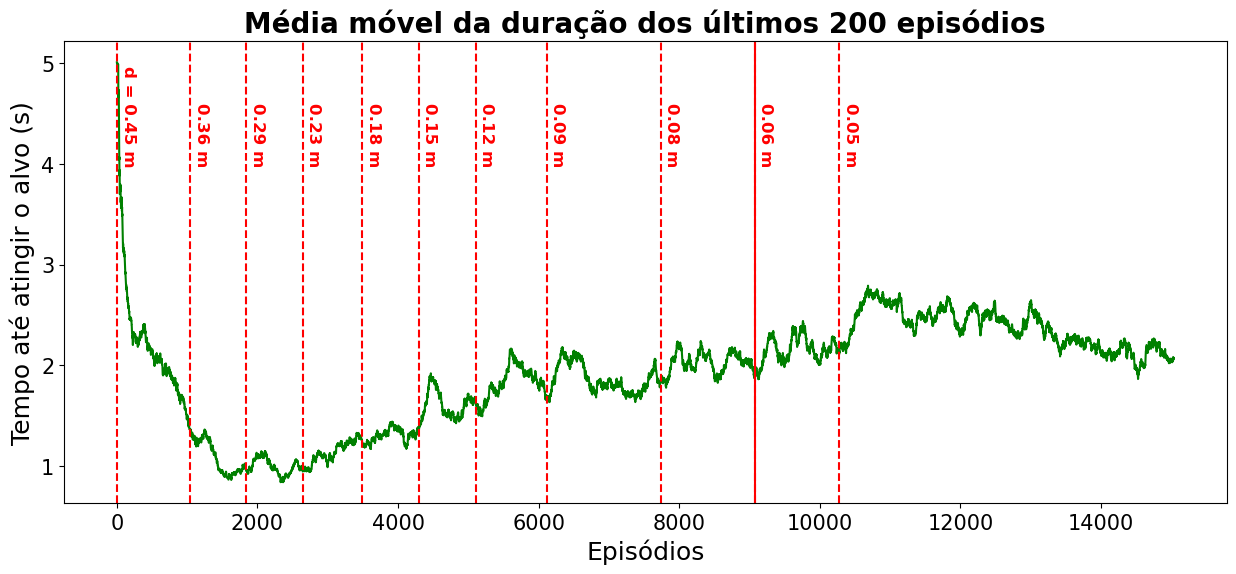

In [48]:
def plot_learning_curve(x, scores, figure_file):
    running_avg_score = np.zeros(len(scores))
    for i in range(len(running_avg_score)):
        running_avg_score[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg_score, '-b')
    plt.ylim(-300,200)
    plt.xticks(fontsize='15')
    plt.yticks(fontsize='15')
    plt.xlabel('Episódios',fontsize='18')
    plt.ylabel('Pontuação',fontsize='18')
    plt.axvline(x=next_level_points[-3], color='red')
    plt.axvline(0,color='red',linestyle='--')
    plt.text(-300,-200,'d = 0.45 m',rotation=-90,color='red',weight='bold',size='12')
    d = 0.45
    for p in next_level_points[:-1]:
        d = d*0.8
        plt.text(p+50,-200,'%.2f m'%d,rotation=-90,color='red',weight='bold',size='12')
        plt.axvline(x=p, color='red', linestyle='--')
    plt.title('Média móvel das últimas 100 pontuações',size='20',weight='bold')
    plt.savefig(figure_file)

def plot_success_curve(x, successes, figure_file):
    running_success_rate = np.zeros(len(successes))
    for i in range(len(running_success_rate)):
        running_success_rate[i] = np.mean(successes[max(0, i-50):(i+1)])
    plt.plot(x, running_success_rate, '-g')
    plt.xticks(fontsize='15')
    plt.yticks(fontsize='15')
    plt.xlabel('Episódios',fontsize='18')
    plt.ylabel('Taxa de sucesso',fontsize='18')
    plt.axvline(x=next_level_points[-3], color='red')
    plt.axvline(0,color='red',linestyle='--')
    plt.text(65,0.12,'d = 0.45 m',rotation=-90,color='red',weight='bold',size='12')
    d = 0.45
    for p in next_level_points[:-1]:
        d = d*0.8
        plt.text(p+50,0.12,'%.2f m'%d,rotation=-90,color='red',weight='bold',size='12')
        plt.axvline(x=p, color='red', linestyle='--')
    plt.title('Taxa de sucesso dos últimos 50 episódios',size='20',weight='bold')
    plt.savefig(figure_file)

def plot_step_curve(x, steps, figure_file):
    running_step_avg = np.zeros(len(steps))
    for i in range(len(running_step_avg)):
        running_step_avg[i] = np.mean(steps[max(0, i-200):(i+1)])
    plt.plot(x, running_step_avg, '-g')
    plt.xticks(fontsize='15')
    plt.yticks(fontsize='15')
    plt.xlabel('Episódios',fontsize='18')
    plt.ylabel('Tempo até atingir o alvo (s)',fontsize='18')
    plt.axvline(x=next_level_points[-3], color='red')
    plt.axvline(0,color='red',linestyle='--')
    plt.text(65,4,'d = 0.45 m',rotation=-90,color='red',weight='bold',size='12')
    d = 0.45
    for p in next_level_points[:-1]:
        d = d*0.8
        plt.text(p+50,4,'%.2f m'%d,rotation=-90,color='red',weight='bold',size='12')
        plt.axvline(x=p, color='red', linestyle='--')
    plt.title('Média móvel da duração dos últimos 200 episódios',size='20',weight='bold')
    plt.savefig(figure_file)

x = [i+1 for i in range(15033)]
%matplotlib inline
plt.figure('learning',figsize=(15,6))
plot_learning_curve(x, score_history, figure_file_score)
plt.figure('catching',figsize=(15,6))
plot_success_curve(x, success_history, figure_file_catchrate)
plt.figure('steps',figsize=(15,6))
plot_step_curve(x, time_history, figure_file_steps)